# Flair Classification using FastAI

In [0]:
from fastai.text import *
import pandas as pd
%matplotlib inline

In [0]:
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

In [0]:
train['Flair'].unique()

array(['Non-Political', 'Coronavirus', 'Politics', 'Policy/Economy', 'Food', 'Science/Technology', 'Business/Finance',
       'Photography', 'Sports'], dtype=object)

In [0]:
train.head()

,PostUploadTime,Headline,Flair,Rating,UserName,UserPostKarma,UserCommentKarma,Id,PostSource,NumComments,Comments,PostBody
0,1.587106e+09,Man Arrested For Allegedly Spitting On Manipur...,Non-Political,111,ReallyRedditLover,1008.0,116.0,g2ph3l,https://www.ndtv.com/mumbai-news/man-arrested-...,7,">The accused was identified as **Amir Khan** ,...",NaN
1,1.587106e+09,Bought air tickets during lockdown? Full refun...,Coronavirus,8,ReallyRedditLover,1008.0,116.0,g2pg1d,https://timesofindia.indiatimes.com/business/i...,2,"So, If I booked the ticket on 21st for 26th Ma...",NaN
2,1.587105e+09,Bollywood Nazis: A Tale of Two Sisters,Politics,19,iSalaamU,32174.0,14938.0,g2pd5o,https://www.reddit.com/r/india/comments/g2pd5o...,7,Woah so permanent ban right ? Not temporary .....,"Yesterday, Twitter permanently suspended the a..."
3,1.587105e+09,"On this occasion of Rongāli bihu, I'd love to ...",Non-Political,10,deboo117,8370.0,2700.0,g2p97t,https://open.spotify.com/playlist/21uBCM64wmKV...,0,NaN,NaN
4,1.587104e+09,A Tweet Asking For Muslims And Journalists To ...,Coronavirus,1,NaN,NaN,NaN,g2ovv5,https://www.buzzfeednews.com/article/pranavdix...,1,NaN,[deleted]


In [0]:
valid.head()

,PostUploadTime,Headline,Flair,Rating,UserName,UserPostKarma,UserCommentKarma,Id,PostSource,NumComments,Comments,PostBody
0,1.587444e+09,I want to be calm like that guy sitting on the...,Photography,4,OtsuKotsu,1209.0,2681.0,g50xtt,https://i.redd.it/kjkywsmcc1u41.jpg,0,NaN,NaN
1,1.587444e+09,Coronavirus Proof Greetings,Coronavirus,1,Brilliant_Bharat,1.0,0.0,g50xbz,https://www.brilliantbharat.com/2020/04/19/cor...,0,NaN,NaN
2,1.587444e+09,1.7 million dollar cost project in Pakistan.,Business/Finance,1,Deejhons786,1330.0,22.0,g50uin,https://youtu.be/GsUWJ9MTHWc,0,NaN,NaN
3,1.587444e+09,Refer and Earn- Rs. 5 per refer - No minimum w...,Business/Finance,1,HashOneandOnly,1.0,0.0,g50q4h,https://www.reddit.com/r/india/comments/g50q4h...,0,NaN,[removed]
4,1.587444e+09,Amazon reviews gold ! A 'massager' that clearl...,Non-Political,6,zakiiboy,15811.0,2902.0,g50nld,https://i.redd.it/5tuf59qq91u41.jpg,1,"Yes, the product description is not a giveaway...",NaN


# Language Model
First creating a language model from the text available in the train and test set. 

Appending all the text available in the headline, author, postbody, comments columns of both the dataframes into one single textbody column

In [0]:
text = []
for dataframe in [train, valid]:
  text.extend(dataframe['Headline'].map(str) + dataframe['UserName'].map(str) + dataframe['PostBody'].map(str) + dataframe['Comments'].map(str))
df = pd.DataFrame({'text':text})

`df` is the data prepared for language model, as there are no labels required in language model I have dropped the Flair column

In [0]:
df.head()

,text
0,Man Arrested For Allegedly Spitting On Manipur...
1,Bought air tickets during lockdown? Full refun...
2,Bollywood Nazis: A Tale of Two SistersiSalaamU...
3,"On this occasion of Rongāli bihu, I'd love to ..."
4,A Tweet Asking For Muslims And Journalists To ...


In [0]:
# defining batch size
bs=50
# creating data bunch using fastai's textlist api
data_lm = (TextList.from_df(df, cols='text')
          # splitting data into train(0.8) and test(0.2) randomly
          .split_by_rand_pct(0.2)
          # labelling for language model
          .label_for_lm()
          #  creating data bunch of batch size bs
          .databunch(bs=bs))
# saving the lm databunch to use later for classification
data_lm.save('data_lm')

In [0]:
# using AWD_LSTM architecure for language modelling
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.6)

In [0]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(19560, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(19560, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=19560, bias=True)
    (output_dp): RNNDropout()
  )
)

epoch,train_loss,valid_loss,accuracy,time


Exception ignored in: <bound method _ConnectionBase.__del__ of <multiprocessing.connection.Connection object at 0x7f5f77457ef0>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


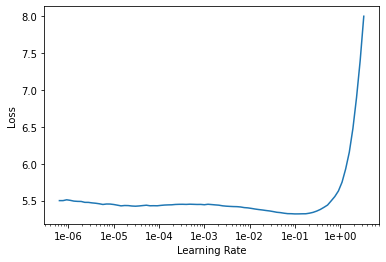

In [0]:
learn.lr_find()
learn.recorder.plot()

Here it is good to take the learning rate where the curve is still moving downward rather than the lr at the minima of the curve

In [0]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.626995,4.348191,0.267879,02:16
1,4.362378,4.194059,0.277120,02:22
2,4.240588,4.207509,0.276588,02:22
3,4.101108,4.205788,0.277765,02:23
4,4.004673,4.200269,0.278469,02:22
5,3.886517,4.188310,0.281164,02:23
6,3.748521,4.176147,0.282425,02:23
7,3.666495,4.167759,0.284077,02:23
8,3.556187,4.163549,0.284743,02:23
9,3.495876,4.162990,0.285059,02:23


In [0]:
learn.unfreeze()
learn.fit_one_cycle(3,1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.139073,4.304791,0.270485,02:27
1,3.986545,4.143645,0.286885,02:27
2,3.506133,4.087173,0.296460,02:28


In [0]:
# the valid loss is still decreasing I can still train it
# first save the current model
learn.freeze()
learn.save_encoder('base_lm.pth')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.651045,4.200371,0.283038,02:28
1,4.000079,4.241140,0.278093,02:28
2,3.828896,4.169321,0.287173,02:28
3,3.453923,4.126180,0.295322,02:27
4,3.140245,4.156529,0.295587,02:28


In [0]:
# save the language model
learn.freeze()
learn.save_encoder('fin_tuned')

## Classification Task
Now the language model is ready I can use a decoder network along with the language model for classification

In [0]:
Flair = []
Flair.extend(train['Flair'].map(str))
Flair.extend(valid['Flair'].map(str))
# df already contains the text, here i will add their corresponding Flairs
df['flair'] = Flair

In [0]:
df.head()

,text,flair
0,Man Arrested For Allegedly Spitting On Manipur...,Non-Political
1,Bought air tickets during lockdown? Full refun...,Coronavirus
2,Bollywood Nazis: A Tale of Two SistersiSalaamU...,Politics
3,"On this occasion of Rongāli bihu, I'd love to ...",Non-Political
4,A Tweet Asking For Muslims And Journalists To ...,Coronavirus


In [0]:
bs=50
data_lm = load_data(path = '/content/', file='data_lm', bs = bs)

In [0]:
# preparing the classification data
data_cls = (TextList.from_df(df, vocab=data_lm.vocab)
           # splitting the data into training(80%) and test(20%) randomly
           .split_by_rand_pct(0.2)
           # label of the text from the Flair column
           .label_from_df(cols='flair')
           .databunch(bs=16))

In [0]:
data_cls.show_batch(10)

text,target
xxbos xxup its xxup lock xxup on for xxmaj indian xxmaj real xxunk \n \n * * * xxup lock – xxup on means ' xxmaj xxunk ' which refers to the removal of xxunk by making something clear . * * * \n \n xxmaj we never would ’ve imagined a day when 1 / 3rd of world ’s population would be in a lockdown . xxmaj,Business/Finance
"xxbos xxmaj citizenship xxmaj amendment xxunk / xxup caa ) , xxmaj national xxmaj registry of xxmaj indian xxunk / xxup nric ) - the past , present and a possible xxunk internet rabbit hole took me to various places when i was curious to know * how * xxmaj india currently xxunk ' citizenship ' and whether this nationalised version of xxup nrc , xxmaj assam is going to",Policy/Economy
"xxbos xxmaj which xxmaj side xxmaj should i xxmaj choose ? xxunk was recently reading "" xxmaj india xxmaj is xxmaj no xxmaj longer xxmaj india "" ( [ https : / / www.theatlantic.com / magazine / archive / 2020 / 05 / xxunk - in - the - age - of - modi / xxunk / ] ( https : / / www.theatlantic.com / magazine / archive / 2020",Politics
"xxbos i 'm not sure if this has already been shared here as the post is almost 1.5 weeks old . xxmaj but this shows what was the preparedness level two days before xxmaj janata xxmaj curfew and how authorities messed up at the xxup igi xxmaj airport , which probably have lead to local transmission of covid-19 there xxunk post by xxmaj vikram xxmaj sharma on xxup fb \n",Coronavirus
"xxbos xxmaj is xxmaj mamata government in xxmaj west xxmaj bengal as ineffective as its made out to xxunk my friends and i were discussing different states in xxmaj india , their economic state , the kind of leaders it has got , and then there was a long discussion about xxmaj xxunk xxmaj bangal ( xxmaj west xxmaj bengal ) and xxmaj kolkata . \n \n xxmaj my",Politics
"xxbos xxmaj india tests 24 people for one positive case , xxmaj japan tests xxunk , xxmaj italy 6.7 , xxup us tests xxunk ; ca n't say xxmaj india testing less : xxunk is something i have been wondering too . xxmaj among those tested , xxmaj india has a much lower positive to negative ratio than most other countries , which is surprising because xxmaj india had a",Coronavirus
xxbos xxmaj what exactly is the xxup bjp trying to do xxunk have been following their moves closely . xxmaj right from 2013 and the xxmaj anna xxmaj xxunk days - you got to say that the overall scheme was very well planned . \n \n xxmaj they played the xxmaj economy card well and came into power . xxmaj and then things changed as we all know .,Politics
"xxbos xxmaj delhi has not been given a single paisa from the ₹17,000 crore allocated to states . xxmaj here 's xxunk there ! \n \n xxmaj as is being reported by the news , approximately ₹17,000 crore has been allocated by the xxmaj centre to the xxmaj states . xxmaj here is a representative news report : [ "" xxmaj centre grants xxmaj rs xxunk to states to",Policy/Economy
"xxbos xxmaj delhi xxmaj police admits to using drones on civilians without any publicly available legal guidelines in xxunk \n \n https : / / preview.redd.it / xxunk \n \n * * xxmaj tl;dr * * \n \n xxmaj with reports now emerging that the xxmaj delhi xxmaj police is using drones to check for people who are breaking the curfew in xxmaj delhi , we examine",Policy/Economy
"xxbos xxmaj during lockdown , xxmaj uttarakhand xxup cm ( on xxmaj amit xxmaj shah 's orders ) arranged 28 buses to transport 1800 xxmaj gujarati devotees stranded in xxmaj haridwar back to xxmaj ahmedabad . xxmaj uttarakhand workers in xxmaj ahmedabad were then duped of xxmaj rs . 18000 and stranded midway when they tried to use these buses to return xxunk to the story : https : /",Politics


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


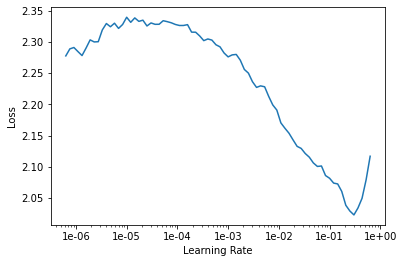

In [0]:
# defining model and optimizer
learn = text_classifier_learner(data_cls, AWD_LSTM, drop_mult = 0.4)
# load the embedding/encoder trained on our text data
learn.load_encoder('fin_tuned')

# plot loss vs learning rate curve
learn.lr_find()
learn.recorder.plot(skip_end=10)

In [0]:
# model -> AWD_LSTM
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(19552, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(19552, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.16000000000000003, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): 

In [0]:
# dry run on data
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.434268,1.326604,0.520596,06:56
1,1.395142,1.237300,0.557453,08:01


In [0]:
# unfreeze the model and run training loop again
learn.unfreeze()
learn.fit_one_cycle(5,1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.431762,1.343671,0.530623,06:56
1,1.400123,2.310741,0.526016,06:39
2,1.246933,1.949404,0.540650,07:44
3,1.048541,1.950147,0.566396,07:12
4,0.816110,2.090378,0.562602,08:16
